# Análise de Emoções nos Hinos da ICM
Este notebook utiliza modelos de NLP para identificar emoções predominantes nos textos dos hinos da coletânea principal da Igreja Cristã Maranata.

O objetivo é classificar os hinos quanto às emoções transmitidas, visualizar a distribuição das emoções e salvar os resultados para futuras análises.

---
**Conteúdo do notebook:**
- Carregamento do modelo de emoções (BERT-pt-emotion)
- Processamento dos textos dos hinos para análise de emoções
- Visualização da distribuição das emoções dominantes
- Estatísticas e exemplos por emoção
- Visualização detalhada (heatmap)
- Extração das 3 emoções mais fortes por hino
- Salvamento dos resultados enriquecidos

Este material é público e pode ser compartilhado para fins de pesquisa, estudo ou divulgação cultural.

# Parte 7 - Análise de Emoção

---

**A seguir:** Carregamento do modelo de emoções e dos dados dos hinos, definição das funções para processamento dos textos e classificação das emoções.

In [1]:
from transformers import pipeline
import pandas as pd
import torch

hinos_analise: pd.DataFrame = pd.read_pickle(
    "..\\assets\\hinos_analise_embeddings_complete.pkl"
)

# Carregar modelo multilíngue de emoções
model_name = "pysentimiento/bert-pt-emotion"
classifier = pipeline(
    "text-classification",
    model=model_name,
    tokenizer=model_name,
    top_k=None,  # Substitui return_all_scores=True (depreciado)
    max_length=512,  # Limite máximo de tokens do BERT
    truncation=True,  # Trunca textos longos automaticamente
    device=-1,  # Força uso da CPU para evitar problemas de memória
)


# Função para juntar e truncar tokens já tratados
def texto_truncado_tokens(tokens, max_tokens=400):
    if not isinstance(tokens, list):
        return ""
    # Trunca a lista de tokens e junta em uma string
    return " ".join(tokens[:max_tokens])


# Classificar emoções usando a coluna token_no_stops
def analisar_emocoes_tokens(tokens):
    try:
        texto = texto_truncado_tokens(tokens)
        if not texto.strip():
            return {}
        resultado = classifier(texto)
        if isinstance(resultado, list) and len(resultado) > 0:
            emocoes_lista = resultado[0]
            if isinstance(emocoes_lista, list):
                return {r["label"]: r["score"] for r in emocoes_lista}
        return {}
    except Exception as e:
        print(f"Erro ao processar texto: {str(e)[:100]}...")
        return {}

c:\ProgramData\anaconda3\envs\hinos-db\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


---

**A seguir:** Processamento dos hinos em lotes para análise de emoções, salvando os resultados e exibindo amostras dos dados processados.

In [2]:
# Processar todos os hinos (pode demorar alguns minutos)
print("Processando análise de emoções para todos os hinos...")
print("Isso pode levar alguns minutos. Progresso:")

import time

start_time = time.time()

# Processar em lotes para mostrar progresso
batch_size = 50
total_batches = len(hinos_analise) // batch_size + 1

all_emotions = []
for i in range(0, len(hinos_analise), batch_size):
    batch = hinos_analise.iloc[i : i + batch_size]
    batch_emotions = batch["tokens_no_stops"].apply(analisar_emocoes_tokens)
    all_emotions.extend(batch_emotions.tolist())

    current_batch = i // batch_size + 1
    print(
        f"Lote {current_batch}/{total_batches} concluído ({i+len(batch)}/{len(hinos_analise)} hinos)"
    )

# Adicionar resultados ao dataframe
hinos_analise["emocoes"] = all_emotions

end_time = time.time()
print(f"\nProcessamento concluído em {end_time - start_time:.1f} segundos!")
print(f"Total de hinos processados: {len(hinos_analise)}")

# Mostrar amostra dos resultados
print("\nAmostra dos resultados:")
for idx, row in hinos_analise.head(10).iterrows():
    emocoes = row["emocoes"]
    if emocoes:
        top_emocao = max(emocoes.items(), key=lambda x: x[1])
        print(f"{row['nome'][:40]}... -> {top_emocao[0]}: {top_emocao[1]:.3f}")
    else:
        print(f"{row['nome'][:40]}... -> Erro no processamento")

Processando análise de emoções para todos os hinos...
Isso pode levar alguns minutos. Progresso:
Lote 1/16 concluído (50/795 hinos)
Lote 2/16 concluído (100/795 hinos)
Lote 3/16 concluído (150/795 hinos)
Lote 4/16 concluído (200/795 hinos)
Lote 5/16 concluído (250/795 hinos)
Lote 6/16 concluído (300/795 hinos)
Lote 7/16 concluído (350/795 hinos)
Lote 8/16 concluído (400/795 hinos)
Lote 9/16 concluído (450/795 hinos)
Lote 10/16 concluído (500/795 hinos)
Lote 11/16 concluído (550/795 hinos)
Lote 12/16 concluído (600/795 hinos)
Lote 13/16 concluído (650/795 hinos)
Lote 14/16 concluído (700/795 hinos)
Lote 15/16 concluído (750/795 hinos)
Lote 16/16 concluído (795/795 hinos)

Processamento concluído em 236.0 segundos!
Total de hinos processados: 795

Amostra dos resultados:
AQUILO QUE FUI NÃO SOU MAIS... -> optimism: 0.677
O SANGUE DE JESUS TEM PODER... -> love: 0.356
O SANGUE DE JESUS TEM PODER PARA SALVAR... -> neutral: 0.911
CLAMO A TI... -> love: 0.667
QUANDO TE PROSTRARES... -> neutral

---

**A seguir:** Visualização e análise dos resultados das emoções, incluindo distribuição das emoções dominantes, estatísticas e exemplos por emoção.

Analisando resultados das emoções...


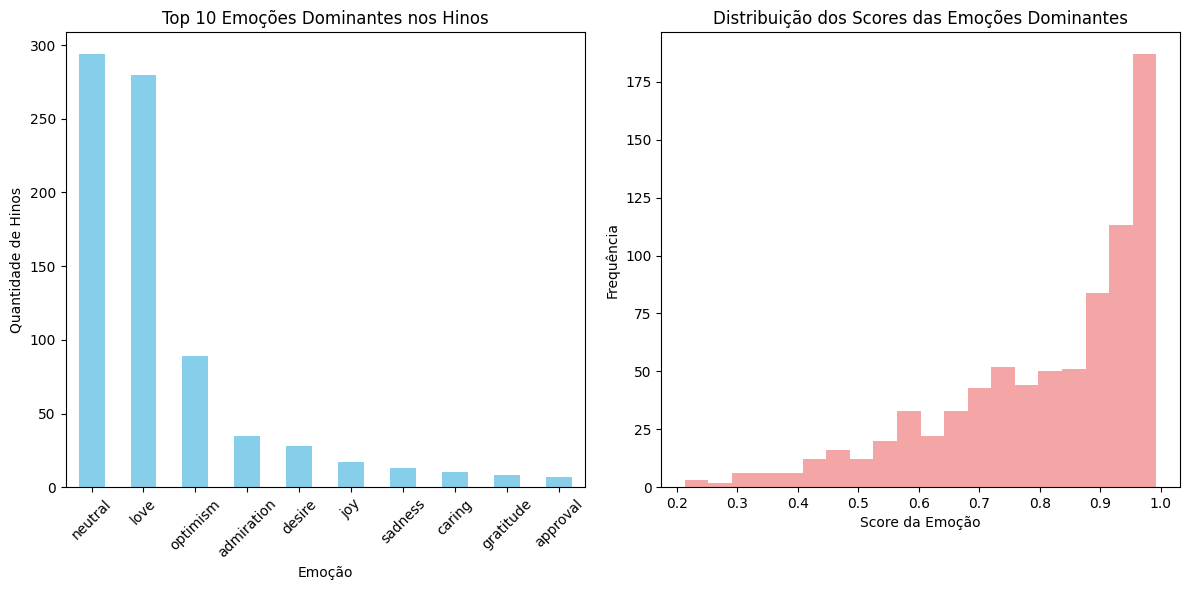


=== ESTATÍSTICAS DAS EMOÇÕES ===
Total de hinos analisados: 795
Hinos com erro no processamento: 0
Score médio das emoções dominantes: 0.809

Top 10 emoções mais frequentes:
 1. neutral        : 294 hinos (37.0%)
 2. love           : 280 hinos (35.2%)
 3. optimism       :  89 hinos (11.2%)
 4. admiration     :  35 hinos ( 4.4%)
 5. desire         :  28 hinos ( 3.5%)
 6. joy            :  17 hinos ( 2.1%)
 7. sadness        :  13 hinos ( 1.6%)
 8. caring         :  10 hinos ( 1.3%)
 9. gratitude      :   8 hinos ( 1.0%)
10. approval       :   7 hinos ( 0.9%)

=== EXEMPLOS POR EMOÇÃO ===

NEUTRAL (score: 0.911):
  Hino: O SANGUE DE JESUS TEM PODER PARA SALVAR
  Texto: O SANGUE DE JESUS TEM PODER O SANGUE DE JESUS, O SANGUE DE JESUS, O SANGUE DE JESUS TEM PODER. O SAN...

LOVE (score: 0.356):
  Hino: O SANGUE DE JESUS TEM PODER
  Texto: O SANGUE DE JESUS TEM PODER, PODER QUE A MIM PODE VALER, SE COMUNHÃO NÃO POSSO EU SENTIR, SENHOR, DE...

OPTIMISM (score: 0.677):
  Hino: AQUILO QUE FUI 

In [3]:
# Análise e visualização dos resultados de emoções
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Verificar se os dados foram processados
if "emocoes" not in hinos_analise.columns:
    print("Execute a célula anterior primeiro para processar as emoções!")
else:
    print("Analisando resultados das emoções...")

    # Extrair a emoção dominante de cada hino
    emocoes_dominantes = []
    scores_dominantes = []

    for emocoes in hinos_analise["emocoes"]:
        if emocoes:
            top_emocao = max(emocoes.items(), key=lambda x: x[1])
            emocoes_dominantes.append(top_emocao[0])
            scores_dominantes.append(top_emocao[1])
        else:
            emocoes_dominantes.append("unknown")
            scores_dominantes.append(0.0)

    hinos_analise["emocao_dominante"] = emocoes_dominantes
    hinos_analise["score_dominante"] = scores_dominantes

    # 1. Distribuição das emoções dominantes
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    emocao_counts = pd.Series(emocoes_dominantes).value_counts().head(10)
    emocao_counts.plot(kind="bar", color="skyblue")
    plt.title("Top 10 Emoções Dominantes nos Hinos")
    plt.xlabel("Emoção")
    plt.ylabel("Quantidade de Hinos")
    plt.xticks(rotation=45)

    # 2. Distribuição dos scores das emoções dominantes
    plt.subplot(1, 2, 2)
    plt.hist(scores_dominantes, bins=20, color="lightcoral", alpha=0.7)
    plt.title("Distribuição dos Scores das Emoções Dominantes")
    plt.xlabel("Score da Emoção")
    plt.ylabel("Frequência")

    plt.tight_layout()
    plt.show()

    # 3. Estatísticas das emoções
    print("\n=== ESTATÍSTICAS DAS EMOÇÕES ===")
    print(f"Total de hinos analisados: {len(hinos_analise)}")
    print(f"Hinos com erro no processamento: {emocoes_dominantes.count('unknown')}")
    print(
        f"Score médio das emoções dominantes: {np.mean([s for s in scores_dominantes if s > 0]):.3f}"
    )

    print("\nTop 10 emoções mais frequentes:")
    for i, (emocao, count) in enumerate(emocao_counts.head(10).items(), 1):
        percentage = (count / len(hinos_analise)) * 100
        print(f"{i:2d}. {emocao:15s}: {count:3d} hinos ({percentage:4.1f}%)")

    # 4. Exemplos de hinos por emoção dominante
    print("\n=== EXEMPLOS POR EMOÇÃO ===")
    for emocao in emocao_counts.head(5).index:
        hinos_emocao = hinos_analise[hinos_analise["emocao_dominante"] == emocao]
        exemplo = hinos_emocao.iloc[0]
        print(f"\n{emocao.upper()} (score: {exemplo['score_dominante']:.3f}):")
        print(f"  Hino: {exemplo['nome']}")
        print(f"  Texto: {exemplo['texto_limpo'][:100]}...")

    print(f"\nProcessamento concluído! Dados salvos com análise de emoções.")

---

**A seguir:** Análise das emoções ignorando a categoria 'neutral', visualização da distribuição e exemplos por emoção sem neutralidade.

Analisando emoções ignorando 'neutral'...


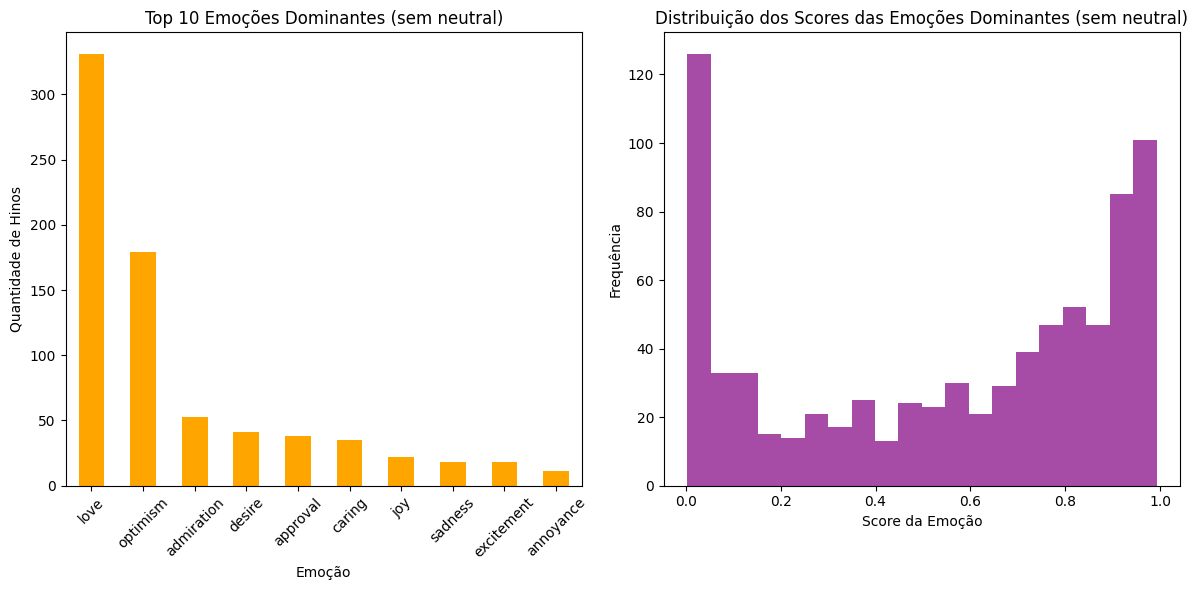


=== ESTATÍSTICAS DAS EMOÇÕES (sem neutral) ===
Total de hinos analisados: 795
Hinos com erro no processamento: 0
Score médio das emoções dominantes: 0.551

Top 10 emoções mais frequentes (sem neutral):
 1. love           : 331 hinos (41.6%)
 2. optimism       : 179 hinos (22.5%)
 3. admiration     :  53 hinos ( 6.7%)
 4. desire         :  41 hinos ( 5.2%)
 5. approval       :  38 hinos ( 4.8%)
 6. caring         :  35 hinos ( 4.4%)
 7. joy            :  22 hinos ( 2.8%)
 8. sadness        :  18 hinos ( 2.3%)
 9. excitement     :  18 hinos ( 2.3%)
10. annoyance      :  11 hinos ( 1.4%)

=== EXEMPLOS POR EMOÇÃO (sem neutral) ===

LOVE (score: 0.356):
  Hino: O SANGUE DE JESUS TEM PODER
  Texto: O SANGUE DE JESUS TEM PODER, PODER QUE A MIM PODE VALER, SE COMUNHÃO NÃO POSSO EU SENTIR, SENHOR, DE...

OPTIMISM (score: 0.677):
  Hino: AQUILO QUE FUI NÃO SOU MAIS
  Texto: AQUILO QUE FUI NÃO SOU MAIS, NEM SOU TUDO O QUE DEVO SER; JÁ SOU PELA GRAÇA O QUE SOU E AO VÊ-LO EST...

ADMIRATION (score

In [4]:
# Análise ignorando a emoção 'neutral'
print("Analisando emoções ignorando 'neutral'...")
emocoes_dominantes_sem_neutral = []
scores_dominantes_sem_neutral = []
for emocoes in hinos_analise["emocoes"]:
    if emocoes:
        # Remove 'neutral' se existir
        emocoes_filtrado = {k: v for k, v in emocoes.items() if k != "neutral"}
        if emocoes_filtrado:
            top_emocao = max(emocoes_filtrado.items(), key=lambda x: x[1])
            emocoes_dominantes_sem_neutral.append(top_emocao[0])
            scores_dominantes_sem_neutral.append(top_emocao[1])
        else:
            emocoes_dominantes_sem_neutral.append("unknown")
            scores_dominantes_sem_neutral.append(0.0)
    else:
        emocoes_dominantes_sem_neutral.append("unknown")
        scores_dominantes_sem_neutral.append(0.0)

hinos_analise["emocao_dominante_sem_neutral"] = emocoes_dominantes_sem_neutral
hinos_analise["score_dominante_sem_neutral"] = scores_dominantes_sem_neutral

# Visualização e estatísticas
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
emocao_counts = pd.Series(emocoes_dominantes_sem_neutral).value_counts().head(10)
emocao_counts.plot(kind="bar", color="orange")
plt.title("Top 10 Emoções Dominantes (sem neutral)")
plt.xlabel("Emoção")
plt.ylabel("Quantidade de Hinos")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(
    [s for s in scores_dominantes_sem_neutral if s > 0],
    bins=20,
    color="purple",
    alpha=0.7,
)
plt.title("Distribuição dos Scores das Emoções Dominantes (sem neutral)")
plt.xlabel("Score da Emoção")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

print("\n=== ESTATÍSTICAS DAS EMOÇÕES (sem neutral) ===")
print(f"Total de hinos analisados: {len(hinos_analise)}")
print(
    f"Hinos com erro no processamento: {emocoes_dominantes_sem_neutral.count('unknown')}"
)
print(
    f"Score médio das emoções dominantes: {np.mean([s for s in scores_dominantes_sem_neutral if s > 0]):.3f}"
)

print("\nTop 10 emoções mais frequentes (sem neutral):")
for i, (emocao, count) in enumerate(emocao_counts.head(10).items(), 1):
    percentage = (count / len(hinos_analise)) * 100
    print(f"{i:2d}. {emocao:15s}: {count:3d} hinos ({percentage:4.1f}%)")

print("\n=== EXEMPLOS POR EMOÇÃO (sem neutral) ===")
for emocao in emocao_counts.head(5).index:
    hinos_emocao = hinos_analise[
        hinos_analise["emocao_dominante_sem_neutral"] == emocao
    ]
    exemplo = hinos_emocao.iloc[0]
    print(f"\n{emocao.upper()} (score: {exemplo['score_dominante_sem_neutral']:.3f}):")
    print(f"  Hino: {exemplo['nome']}")
    print(f"  Texto: {exemplo['texto_limpo'][:100]}...")

---

**A seguir:** Visualização detalhada dos scores de emoções por hino, utilizando heatmap para destacar as emoções principais em uma amostra dos hinos.

Criando heatmap de emoções...


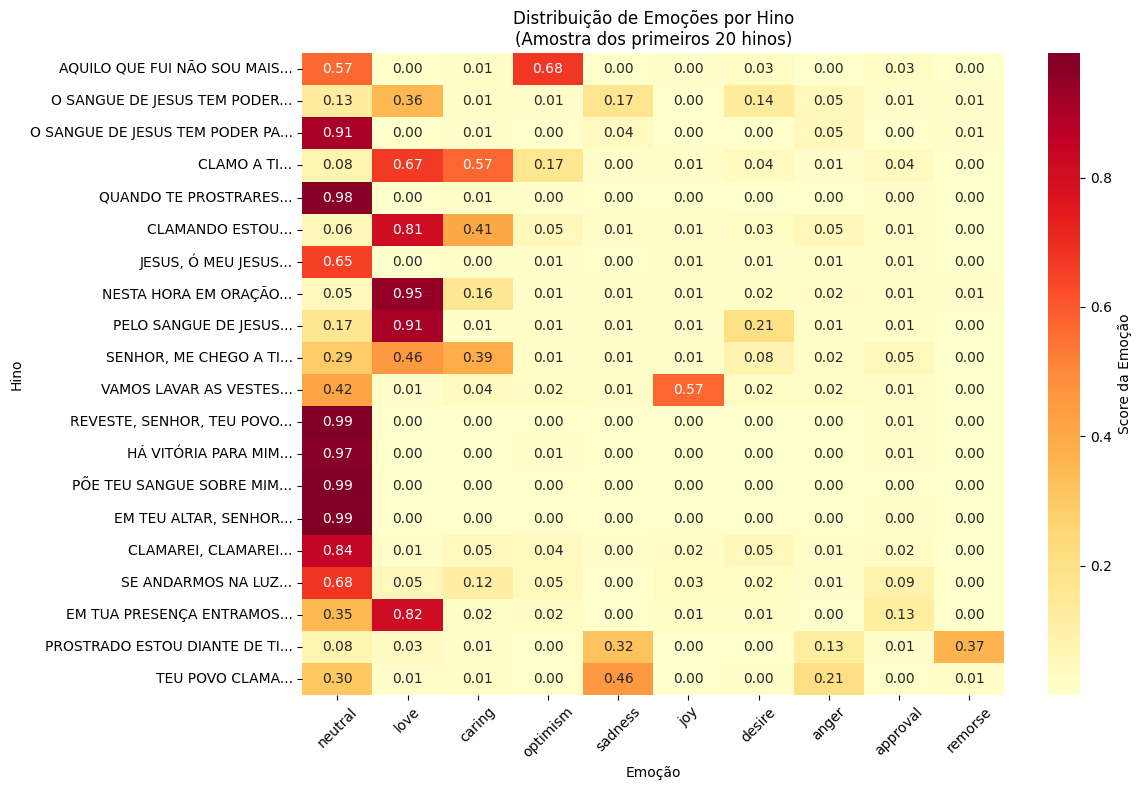

Heatmap criado com 20 hinos e 10 emoções principais.
Emoções visualizadas: ['neutral', 'love', 'caring', 'optimism', 'sadness', 'joy', 'desire', 'anger', 'approval', 'remorse']


In [5]:
# Visualização detalhada: Heatmap de emoções por hino
import seaborn as sns
import matplotlib.pyplot as plt

# Verificar se os dados foram processados
if "emocoes" not in hinos_analise.columns:
    print("Execute as células anteriores primeiro para processar as emoções!")
else:
    print("Criando heatmap de emoções...")

    # Expandir as emoções em colunas numéricas para uma amostra
    # (usar todos os hinos seria muito denso para visualizar)
    amostra_viz = hinos_analise.head(20).copy()  # Primeiros 20 hinos

    # Criar dataframe com as emoções expandidas
    emocoes_expandidas = []
    nomes_hinos = []

    for idx, row in amostra_viz.iterrows():
        if row["emocoes"]:
            emocoes_expandidas.append(row["emocoes"])
            nomes_hinos.append(row["nome"][:30] + "...")  # Truncar nomes longos

    if emocoes_expandidas:
        emo_df = pd.DataFrame(emocoes_expandidas, index=nomes_hinos)

        # Selecionar apenas as emoções mais comuns para visualização
        emocoes_principais = emo_df.mean().nlargest(10).index
        emo_df_filtrado = emo_df[emocoes_principais]

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            emo_df_filtrado,
            annot=True,
            cmap="YlOrRd",
            fmt=".2f",
            cbar_kws={"label": "Score da Emoção"},
        )
        plt.title("Distribuição de Emoções por Hino\n(Amostra dos primeiros 20 hinos)")
        plt.xlabel("Emoção")
        plt.ylabel("Hino")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        print(
            f"Heatmap criado com {len(emo_df_filtrado)} hinos e {len(emocoes_principais)} emoções principais."
        )
        print(f"Emoções visualizadas: {list(emocoes_principais)}")
    else:
        print("Nenhuma emoção foi processada com sucesso. Verifique os dados.")

---

**A seguir:** Extração das 3 emoções mais fortes por hino, para facilitar análises e visualizações futuras.

In [6]:
# Criar coluna com as 3 emoções mais dominantes (sem neutral)
def top3_emocoes_sem_neutral(emocoes):
    if not emocoes:
        return []
    # Remove 'neutral'
    emocoes_filtrado = {k: v for k, v in emocoes.items() if k != "neutral"}
    # Ordena por score (do maior para o menor)
    top3 = sorted(emocoes_filtrado.items(), key=lambda x: x[1], reverse=True)[:3]
    # Retorna só os nomes das emoções
    return [e[0] for e in top3]


hinos_analise["top3_emocoes"] = hinos_analise["emocoes"].apply(top3_emocoes_sem_neutral)

# Exemplo de visualização
print(hinos_analise[["nome", "top3_emocoes"]].head(10))

                                           nome  \
numero                                            
0                   AQUILO QUE FUI NÃO SOU MAIS   
1                   O SANGUE DE JESUS TEM PODER   
2       O SANGUE DE JESUS TEM PODER PARA SALVAR   
3                                    CLAMO A TI   
4                          QUANDO TE PROSTRARES   
5                                CLAMANDO ESTOU   
6                            JESUS, Ó MEU JESUS   
7                          NESTA HORA EM ORAÇÃO   
8                          PELO SANGUE DE JESUS   
9                         SENHOR, ME CHEGO A TI   

                              top3_emocoes  
numero                                      
0             [optimism, desire, approval]  
1                  [love, sadness, desire]  
2              [anger, sadness, annoyance]  
3                 [love, caring, optimism]  
4          [caring, realization, optimism]  
5                    [love, caring, anger]  
6       [excitement, amusem

---

**A seguir:** Salvamento dos resultados enriquecidos com análise de emoções para uso em outras etapas ou aplicações.

In [7]:
hinos_analise_save = hinos_analise.copy()
hinos_analise_save.drop(
    columns=[
        "emocao_dominante",
        "score_dominante",
        "emocao_dominante_sem_neutral",
        "score_dominante_sem_neutral",
    ],
    inplace=True,
)
hinos_analise_save.to_pickle("..\\assets\\hinos_analise_com_emocoes.pkl")

---

**Fim do notebook:** Finalização do processamento, com os dados prontos para exportação e uso em outras análises ou aplicações.